In [111]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import numpy.ma as ma
import time
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

class SVDRec():
    """
    Sources used to build recommender:
    
    https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx
    
    https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf
    
    https://github.com/benlindsay/movielens-analysis/blob/master/05_SGD.ipynb
    
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    """
    def __init__(self,n_factors=100,n_epochs=20,l_r=0.01,reg=0.02,verbose=False):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.l_r = l_r
        self.damping_factor = 10
        self.reg = reg
        self.mu = None
        self.num_movies = None
        self.num_users = None
        self.train_error = None
        self.verbose = verbose
    
    def __str__(self):
        return f"n_factors={self.n_factors},n_epochs={self.n_epochs},learning_rate={self.l_r},regularization={self.reg}"
    
    def _create_movie_user_matrix(self):
        self.M = pd.pivot_table(
                data=self.R,
                values="rating",
                index="userId",
                columns="movieId")
        
        self.movies = set(self.M.columns)
        self.users = set(self.M.index)
    
    def sgd(self):

        self.U = pd.DataFrame(np.random.normal(scale=0.01,size=(self.num_users,self.n_factors)),index=self.users)
        self.I = pd.DataFrame(np.random.normal(scale=0.01,size=(self.num_movies,self.n_factors)),index=self.movies)
        
        for epoch in range(self.n_epochs):
            start = time.time()
            size = self.R.shape[0]
            pred = np.empty([size])
            idx = 0
            for _,row in self.R.iterrows():
                
                u = row["userId"]
                m = row["movieId"]
                r = row["rating"]
                

                qi = self.I.loc[m]
                qu = self.U.loc[u]
                
                bu = self.b_u[u]
                bm = self.b_m[m]
                
                l_r = self.l_r
                reg = self.reg
                
                r_pred = self.predict_entity(u,m)
                
                pred[idx] = r_pred
                
                err = r-r_pred

            
                self.b_u[u] = bu + l_r*(err-(reg*bu))
                
                self.b_m[m] = bm + l_r*(err-(reg*bm))
                
                self.U.loc[u] = qu + l_r*(err*qi -(reg*qu))
                
                self.I.loc[m] = qi + l_r*(err*qu -(reg*qi))
                
                idx += 1
            end = time.time()
            t = end-start
            
            self.train_error = math.sqrt(mean_squared_error(self.R.rating, pred))
            if self.verbose:
                print(f"Epoch nº{epoch},took {t}s, error:{self.train_error}")

    def predict_entity(self,user,movie):
            r_pred = self.mu
            
            if user in self.users:
                r_pred += self.b_u[user]
                
            if movie in self.movies:
                r_pred += self.b_m[movie]
                
            if (movie in self.movies) & (user in self.users):
                r_pred += np.dot(self.I.loc[movie],self.U.loc[user])

            return r_pred

    def fit(self,X,y):
        self.R = X.copy()
        self.R["rating"] = y.copy()
        
        self._create_movie_user_matrix()
        
        self.num_users, self.num_movies = self.M.shape
        self.mu = self.R["rating"].mean()
        
        self.baseline_predictor()
        
        #self.R = self.create_baseline(self.R)
        
        self.sgd()
    
        return self

    
    def baseline_predictor(self):
        num_ratings_per_movie = self.R["movieId"].value_counts()
        num_ratings_per_user = self.R["userId"].value_counts()
        sum_ratings_per_user = self.R.groupby("userId")["rating"].sum()
        sum_ratings_per_movie = self.R.groupby("movieId")["rating"].sum()
        
        self.b_u = (sum_ratings_per_user-(self.mu*num_ratings_per_user))/(num_ratings_per_user+self.damping_factor)
        
        X = self.R.join(self.b_u.rename('b_u'), on='userId')
        X['res'] = X['rating'] - X['b_u'] - self.mu
        num = X[['movieId', 'res']].groupby('movieId')['res'].sum()
        
        denom = num_ratings_per_movie+self.damping_factor
        
        self.b_m = num/denom
    
    def create_baseline(self,X):
        X = X.copy()
        single_baseline = lambda user,movie: self.b_u[user]+self.b_m[movie]+self.mu
        
        X["baseline"] = X.apply (lambda row:single_baseline(row["userId"],row["movieId"]) , axis=1)
        return X


    
    def predict(self,X):
        X_test = X.copy()

        
        X_test["prediction"] = X_test.apply(lambda row:self.predict_entity(row["userId"],row["movieId"]) , axis=1)
        
        return X_test["prediction"]
        
        
        

In [112]:
import pandas as pd
ratings = pd.read_csv("datasets_small/ratings.csv")
ratings = ratings.loc[:,["userId","movieId","rating"]]
ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ratings.drop(columns="rating"), ratings["rating"], test_size=0.30, random_state=42)

In [98]:
model = SVDRec(l_r=0.1,n_epochs=1,verbose=True)
model.fit(X_train,y_train)

Epoch nº0,took 113.67189908027649s, error:0.8779189140169291


In [106]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import time

def cross_val(X,y,model,n_folds=3):
    kf = KFold(n_splits=n_folds)
    total_test_err = 0
    total_train_err = 0
    count = 1
   
    for train_index, val_index in kf.split(X):
        t = 0
        start = time.time()
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)

        err_test = math.sqrt(mean_squared_error(y_val,y_pred))
        err_train = model.train_error
        
        total_test_err = total_test_err + err_test
        total_train_err = total_train_err + err_train
        
        end = time.time()
        
        t = end - start
        print(f"fold={count},RMSE_test={err_test:5},RMSE_train={err_train:5},time={t}")
        
        count += 1
    
    avg_test_err = total_test_err/n_folds
    avg_train_err = total_train_err/n_folds
    
    print(f"Avg Test Error:{avg_test_err} RMSE")
    print(f"Avg Train Error:{avg_train_err} RMSE")
    
    return avg_test_err,avg_train_err




def grid_search(X_train,y_train,param,values):
    result_df = pd.DataFrame(columns=["n_epochs","n_factors","l_r","reg","RMSE_train","RMSE_test"])
    if param == "l_r":
        for v in values:
            model = SVDRec(l_r=v)
            print(model)
            error_val,error_train = cross_val(X_train,y_train,model,3)
            result_df = result_df.append({"n_epochs":model.n_epochs,"n_factors":model.n_factors,"l_r":model.l_r,"reg":mode.reg,"RMSE_train":error_train,"RMSE_test":error_val},ignore_index=True)
    if param == "reg":
        for v in values:
            model = SVDRec(reg=v)
            print(model)
            error_val,error_train = cross_val(X_train,y_train,model,3)
            result_df = result_df.append({"n_epochs":model.n_epochs,"n_factors":model.n_factors,"l_r":model.l_r,"reg":mode.reg,"RMSE_train":error_train,"RMSE_test":error_val},ignore_index=True)
    if param == "n_factors":
        for v in values:
            model = SVDRec(n_factors=v)
            print(model)
            error_val,error_train = cross_val(X_train,y_train,model,3)
            result_df = result_df.append({"n_epochs":model.n_epochs,"n_factors":model.n_factors,"l_r":model.l_r,"reg":mode.reg,"RMSE_train":error_train,"RMSE_test":error_val},ignore_index=True)
    if param == "n_epochs":
        for v in values:
            model = SVDRec(n_epochs=v)
            print(model)
            error_val,error_train = cross_val(X_train,y_train,model,3)
            result_df = result_df.append({"n_epochs":model.n_epochs,"n_factors":model.n_factors,"l_r":model.l_r,"reg":mode.reg,"RMSE_train":error_train,"RMSE_test":error_val},ignore_index=True)
    return result_df

In [107]:
df = grid_search(X_train,y_train,"n_epochs",[10,15,20,25])

n_factors=100,n_epochs=10,learning_rate=0.005,regularization=0.02
fold=1,RMSE_test=0.8790648651877705,RMSE_train=0.8226492277891577,time=886.3159909248352
fold=2,RMSE_test=0.8750397835100577,RMSE_train=0.8241523828357408,time=896.0592138767242
fold=3,RMSE_test=0.8883186030812033,RMSE_train=0.8175849303858618,time=871.620044708252
Avg Test Error:0.8808077505930104 RMSE
Avg Train Error:0.8214621803369201 RMSE
n_factors=100,n_epochs=15,learning_rate=0.005,regularization=0.02
fold=1,RMSE_test=0.8777195337730261,RMSE_train=0.8150315557408466,time=1230.5839083194733
fold=2,RMSE_test=0.8735922774698835,RMSE_train=0.8165419559377958,time=1291.846624135971
fold=3,RMSE_test=0.887290635795656,RMSE_train=0.809951959668648,time=1320.507913351059
Avg Test Error:0.8795341490128553 RMSE
Avg Train Error:0.8138418237824302 RMSE
n_factors=100,n_epochs=20,learning_rate=0.005,regularization=0.02
fold=1,RMSE_test=0.8769483745356005,RMSE_train=0.8083468155938377,time=1744.7287900447845
fold=2,RMSE_test=0.872

In [108]:
df

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,10.0,100.0,0.005,0.02,0.821462,0.880808
1,15.0,100.0,0.005,0.02,0.813842,0.879534
2,20.0,100.0,0.005,0.02,0.807128,0.878824
3,25.0,100.0,0.005,0.02,0.800499,0.878369


In [109]:
df = grid_search(X_train,y_train,"l_r",[0.1,0.01,0.001,0.0001])

n_factors=100,n_epochs=20,learning_rate=0.1,regularization=0.02
fold=1,RMSE_test=0.8963979684684349,RMSE_train=0.09969178909227171,time=1569.298796415329
fold=2,RMSE_test=0.8965839433187689,RMSE_train=0.09874431852014653,time=1575.908175945282
fold=3,RMSE_test=0.9030764074183053,RMSE_train=0.10009675993800515,time=1602.281653881073
Avg Test Error:0.8986861064018363 RMSE
Avg Train Error:0.09951095585014114 RMSE
n_factors=100,n_epochs=20,learning_rate=0.01,regularization=0.02
fold=1,RMSE_test=0.8753578884603697,RMSE_train=0.7715362542692381,time=1749.4201300144196
fold=2,RMSE_test=0.871195981070179,RMSE_train=0.7739104671927394,time=1745.001938343048
fold=3,RMSE_test=0.8855172313081323,RMSE_train=0.7683698030654058,time=13594.890384197235
Avg Test Error:0.8773570336128937 RMSE
Avg Train Error:0.7712721748424611 RMSE
n_factors=100,n_epochs=20,learning_rate=0.001,regularization=0.02
fold=1,RMSE_test=0.8821499967059601,RMSE_train=0.8310426054470798,time=1588.903082370758
fold=2,RMSE_test=0.

In [116]:
df

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,100.0,0.1000,0.02,0.099511,0.898686
1,20.0,100.0,0.0100,0.02,0.771272,0.877357
2,20.0,100.0,0.0010,0.02,0.829891,0.883900
3,20.0,100.0,0.0001,0.02,0.840733,0.888942


In [113]:
df2 = grid_search(X_train,y_train,"reg",[0.1,0.01,0.001])

n_factors=100,n_epochs=20,learning_rate=0.01,regularization=0.1
fold=1,RMSE_test=0.8765066666234347,RMSE_train=0.8010231018680379,time=1610.4444019794464
fold=2,RMSE_test=0.8731648451124253,RMSE_train=0.8024425658055666,time=1991.879179239273
fold=3,RMSE_test=0.8863981000942368,RMSE_train=0.795937622280157,time=1452.1320056915283
Avg Test Error:0.8786898706100322 RMSE
Avg Train Error:0.7998010966512538 RMSE
n_factors=100,n_epochs=20,learning_rate=0.01,regularization=0.01
fold=1,RMSE_test=0.8740483603483146,RMSE_train=0.7487177452325069,time=1488.1497666835785
fold=2,RMSE_test=0.8705361744145513,RMSE_train=0.7535210304819243,time=1473.2599892616272
fold=3,RMSE_test=0.885256443973339,RMSE_train=0.7465063681342661,time=1455.9144451618195
Avg Test Error:0.8766136595787349 RMSE
Avg Train Error:0.7495817146162324 RMSE
n_factors=100,n_epochs=20,learning_rate=0.01,regularization=0.001
fold=1,RMSE_test=0.8741602818494669,RMSE_train=0.7185559329387844,time=1467.3698151111603
fold=2,RMSE_test=0.8

In [114]:
df2

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,100.0,0.01,0.02,0.799801,0.878690
1,20.0,100.0,0.01,0.02,0.749582,0.876614
2,20.0,100.0,0.01,0.02,0.718165,0.876336


In [115]:
df3 = grid_search(X_train,y_train,"n_factors",[25,50,75,100])

n_factors=25,n_epochs=20,learning_rate=0.01,regularization=0.02
fold=1,RMSE_test=0.8764342251274008,RMSE_train=0.7924629221033538,time=4677.354007482529
fold=2,RMSE_test=0.8724002895009264,RMSE_train=0.7942149837616663,time=3679.8461515903473
fold=3,RMSE_test=0.8867722026065995,RMSE_train=0.788314179932431,time=1706.6789338588715
Avg Test Error:0.8785355724116423 RMSE
Avg Train Error:0.7916640285991504 RMSE
n_factors=50,n_epochs=20,learning_rate=0.01,regularization=0.02
fold=1,RMSE_test=0.8762374420374749,RMSE_train=0.7861094094153859,time=1695.8842599391937
fold=2,RMSE_test=0.8720310079571102,RMSE_train=0.7871418443383522,time=1515.3713660240173
fold=3,RMSE_test=0.8865551072883056,RMSE_train=0.7824029022586716,time=1490.9052810668945
Avg Test Error:0.878274519094297 RMSE
Avg Train Error:0.7852180520041365 RMSE
n_factors=75,n_epochs=20,learning_rate=0.01,regularization=0.02
fold=1,RMSE_test=0.8755946250957477,RMSE_train=0.778991909673378,time=1459.5583412647247
fold=2,RMSE_test=0.87150

KeyboardInterrupt: 

In [117]:
df1 = df
df1

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,100.0,0.1000,0.02,0.099511,0.898686
1,20.0,100.0,0.0100,0.02,0.771272,0.877357
2,20.0,100.0,0.0010,0.02,0.829891,0.883900
3,20.0,100.0,0.0001,0.02,0.840733,0.888942


In [177]:
df1 = df1.sort_values(by=['l_r'],ascending=False)

In [179]:
df1 = df1.drop(df1.index[0])

In [180]:
df1

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
1,20.0,100.0,0.0100,0.02,0.771272,0.877357
4,20.0,100.0,0.0050,0.02,0.807128,0.878824
2,20.0,100.0,0.0010,0.02,0.829891,0.883900
3,20.0,100.0,0.0001,0.02,0.840733,0.888942


In [141]:
df = pd.DataFrame({"n_epochs":[10.0,15.0,20.0,25.0],
                  "n_factors":[100.0,100.0,100.0,100.0],
                  "l_r":[0.005,0.005,0.005,0.005],
                  "reg":[0.02,0.02,0.02,0.02],
                  "RMSE_train":[0.821462,0.813842,0.807128,0.800499],
                  "RMSE_test":[0.880808,0.879534,0.878824,0.878369]})


In [152]:
df

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,10.0,100.0,0.005,0.02,0.821462,0.880808
1,15.0,100.0,0.005,0.02,0.813842,0.879534
2,20.0,100.0,0.005,0.02,0.807128,0.878824
3,25.0,100.0,0.005,0.02,0.800499,0.878369


In [118]:
df1 = df.append({'n_epochs' : 20.0 , 'n_factors' : 100,'l_r' : 0.005,'reg' : 0.02,'RMSE_train' : 0.807128,'RMSE_test' : 0.878824} , ignore_index=True)
df1

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,100.0,0.1000,0.02,0.099511,0.898686
1,20.0,100.0,0.0100,0.02,0.771272,0.877357
2,20.0,100.0,0.0010,0.02,0.829891,0.883900
3,20.0,100.0,0.0001,0.02,0.840733,0.888942
4,20.0,100.0,0.0050,0.02,0.807128,0.878824


In [143]:

df2 = pd.DataFrame({"n_epochs":[20.0,20.0,20.0,20.0],
                    "n_factors":[100.0,100.0,100.0,100.0],
                    "l_r":[0.01,0.01,0.01,0.01],
                    "reg":[0.1,0.01,0.02,0.001],
                    "RMSE_train":[0.799801,0.749585,0.771272,0.718165],
                    "RMSE_test":[0.878690,0.876614,0.877357,0.876336]})

In [191]:
df2 = df2.sort_values(by=['reg'],ascending=False)
df2

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,100.0,0.01,0.100,0.799801,0.878690
2,20.0,100.0,0.01,0.020,0.771272,0.877357
1,20.0,100.0,0.01,0.010,0.749585,0.876614
3,20.0,100.0,0.01,0.001,0.718165,0.876336


In [147]:
df3 = pd.DataFrame({"n_epochs":[20.0,20.0,20.0,20.0],
                    "n_factors":[25.0,50.0,75.0,100.0],
                    "l_r":[0.01,0.01,0.01,0.01],
                    "reg":[0.02,0.02,0.02,0.02],
                    "RMSE_train":[0.791664,0.785218,0.777816,0.771272],
                    "RMSE_test":[0.878535,0.878274,0.877732,0.877357]})
df3

,n_epochs,n_factors,l_r,reg,RMSE_train,RMSE_test
0,20.0,25.0,0.01,0.02,0.791664,0.878535
1,20.0,50.0,0.01,0.02,0.785218,0.878274
2,20.0,75.0,0.01,0.02,0.777816,0.877732
3,20.0,100.0,0.01,0.02,0.771272,0.877357


In [199]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_error(param,title,df_k,y_lim):
    df_p = df_k.copy()
    df_p = df_p.set_index(param)
    plt.style.use("seaborn")

    df_p.RMSE_train.plot(x=param,label="train_err")
    df_p.RMSE_test.plot(x=param,label="test err")
    plt.legend()
    plt.ylim(y_lim)
    plt.ylabel("RMSE")
    plt.title(title);

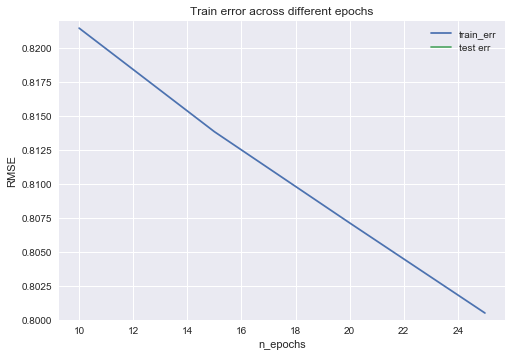

In [200]:
plot_error("n_epochs","Train error across different epochs",df,(0.8,0.822))

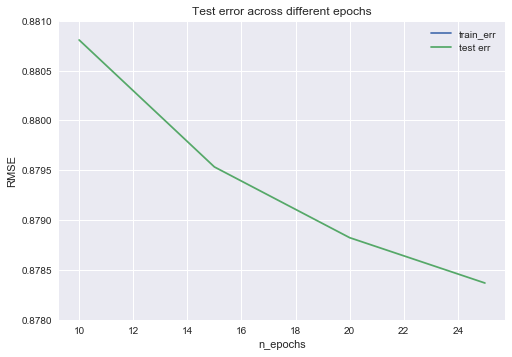

In [201]:
plot_error("n_epochs","Test error across different epochs",df,(0.878,0.881))

In [ ]:
Observations number of epochs:
    (1) - test error seems to decay in an exponential manner although much slower than learning rate
    (2) - train error decays in an almost linear manner
    (3) - the decrease in RMSE between 10 and 25 epochs is only around 0.002 which is expected if we assum the error 
    is able to converge with a low ammount of epochs and 0.02 learning rate

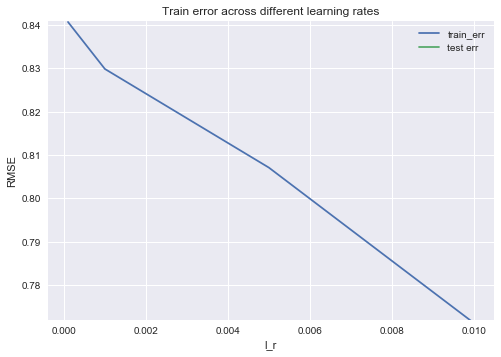

In [202]:
plot_error("l_r","Train error across different learning rates",df1,(0.772,0.841))

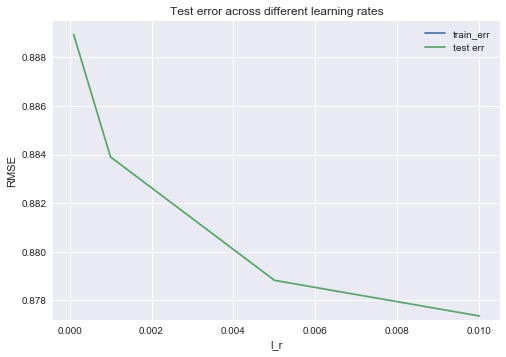

In [203]:
plot_error("l_r","Test error across different learning rates",df1,(0.8772,0.8895))

In [ ]:
Observations learning rate:
    (1) - the test error decreases exponentially with the increase of learning rate
    (2) - the training error shows a much slower decay (weird)
    (3) - chaging the learning rate seems to have the biggest impact on performance with 0.01 RMSE difference between 0.01 and 0.0001
    

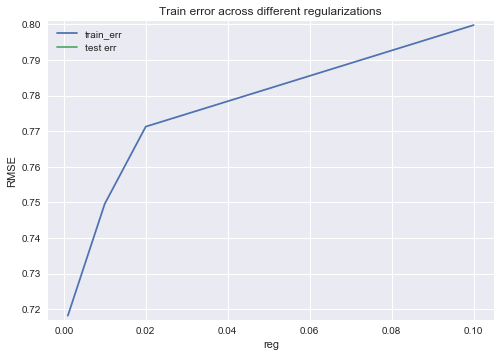

In [204]:
plot_error("reg","Train error across different regularizations",df2,(0.717,0.801))

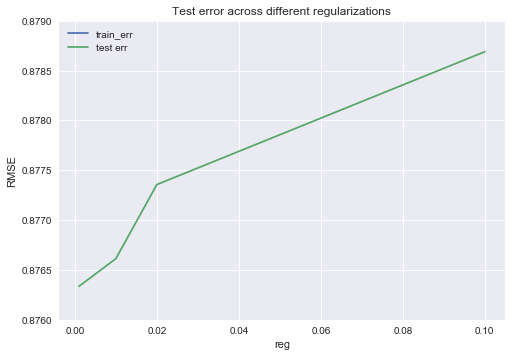

In [205]:
plot_error("reg","Test error across different regularizations",df2,(0.876,0.879))

In [ ]:
Observations regularization:
    (1) - it seems both test and train erro increase with the increase of the regularization parameter, which indicates we should be careful when using high values
    (2) - the effect of the regularization parameter seems to be neglegible (only 0.003 RMSE) between 0.001 and 0.1
    (3) - Point (2) is expected since the regularization parameter is usually used to prevent overfitting and not to increase performance
    
    

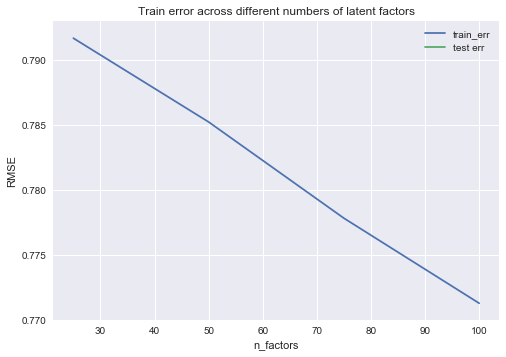

In [206]:
plot_error("n_factors","Train error across different numbers of latent factors",df3,(0.77,0.793))

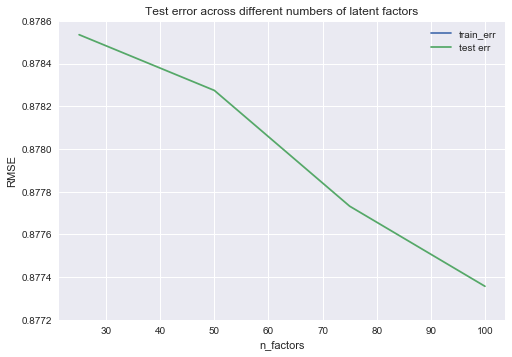

In [207]:
plot_error("n_factors","Test error across different numbers of latent factors",df3,(0.8772,0.8786))

In [ ]:
Observations number of factors:
    (1) - The test error falls pretty heavily between 50 and 75 latent factors and starts to stabilize after that
    (2) - Inside the boundaries we studied (25-100 factors) there is little improvement (~0.0022 RMSE) between 25 (0.8785 RMSE) and 100 (0.8773 RMSE) this indicates that choosing
    a number close to 25 is possibly beneficial since it should decrease computational time
    (3) - Train error seems to fall monotonically and since the test error doesnt seem to increase we dont see signs of overfitting